# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import data as HDF5 Matrix

In [3]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_combined.h5', 'img_train_combined')
img_test = HDF5Matrix('/data/joint_scoring/img_test.h5', 'img_test')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_combined_onehot.h5', 'labels_train_combined_onehot')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot.h5', 'labels_test_onehot')

In [4]:
num_classes = 6

## 2. Model

In [5]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [6]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [7]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [8]:
print(new_folder)

20171027_202112


In [9]:
desc = "Model with oversampled data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [10]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [13]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=2,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch")

Train on 299998 samples, validate on 19611 samples
Epoch 1/25
798s - loss: 1.3371 - acc: 0.4074 - val_loss: 0.7393 - val_acc: 0.7001
Epoch 2/25
687s - loss: 1.1795 - acc: 0.4867 - val_loss: 0.7071 - val_acc: 0.7033
Epoch 3/25
687s - loss: 1.0618 - acc: 0.5537 - val_loss: 0.7384 - val_acc: 0.6897
Epoch 4/25
688s - loss: 0.9322 - acc: 0.6150 - val_loss: 0.6426 - val_acc: 0.7312
Epoch 5/25
687s - loss: 0.8303 - acc: 0.6616 - val_loss: 0.6359 - val_acc: 0.7300
Epoch 6/25
687s - loss: 0.7489 - acc: 0.6987 - val_loss: 0.6587 - val_acc: 0.7257
Epoch 7/25
687s - loss: 0.6838 - acc: 0.7263 - val_loss: 0.6333 - val_acc: 0.7414
Epoch 8/25
687s - loss: 0.6325 - acc: 0.7480 - val_loss: 0.6619 - val_acc: 0.7298
Epoch 9/25
687s - loss: 0.5899 - acc: 0.7654 - val_loss: 0.6582 - val_acc: 0.7394
Epoch 10/25
689s - loss: 0.5526 - acc: 0.7809 - val_loss: 0.6730 - val_acc: 0.7382
Epoch 11/25
689s - loss: 0.5226 - acc: 0.7933 - val_loss: 0.7206 - val_acc: 0.7235
Epoch 12/25
687s - loss: 0.4930 - acc: 0.8057

In [14]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 26.26%


In [15]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

19611/19611 [==============================] - 14s    
             precision    recall  f1-score   support

          0       0.78      0.94      0.85     13286
          1       0.61      0.33      0.43      5369
          2       0.24      0.12      0.16       423
          3       0.18      0.14      0.15       177
          4       0.24      0.08      0.12        98
          5       0.58      0.49      0.53       258

avg / total       0.71      0.74      0.71     19611

[[12463   791    16     3     1    12]
 [ 3453  1789    69    34     5    19]
 [   81   229    51    34     6    22]
 [   19    71    35    24     8    20]
 [   10    28    18    14     8    20]
 [   29    43    28    26     6   126]]


Confusion matrix, without normalization
[[12463   791    16     3     1    12]
 [ 3453  1789    69    34     5    19]
 [   81   229    51    34     6    22]
 [   19    71    35    24     8    20]
 [   10    28    18    14     8    20]
 [   29    43    28    26     6   126]]
Normalized confusion matrix
[[  9.38055096e-01   5.95363541e-02   1.20427518e-03   2.25801596e-04
    7.52671986e-05   9.03206383e-04]
 [  6.43136524e-01   3.33209164e-01   1.28515552e-02   6.33265040e-03
    9.31272118e-04   3.53883405e-03]
 [  1.91489362e-01   5.41371158e-01   1.20567376e-01   8.03782506e-02
    1.41843972e-02   5.20094563e-02]
 [  1.07344633e-01   4.01129944e-01   1.97740113e-01   1.35593220e-01
    4.51977401e-02   1.12994350e-01]
 [  1.02040816e-01   2.85714286e-01   1.83673469e-01   1.42857143e-01
    8.16326531e-02   2.04081633e-01]
 [  1.12403101e-01   1.66666667e-01   1.08527132e-01   1.00775194e-01
    2.32558140e-02   4.88372093e-01]]


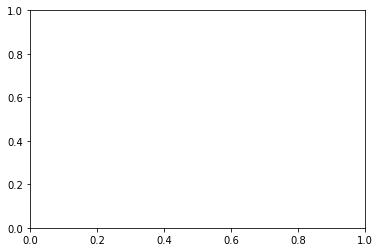

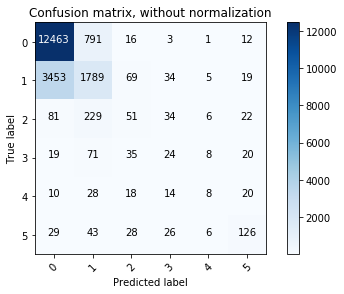

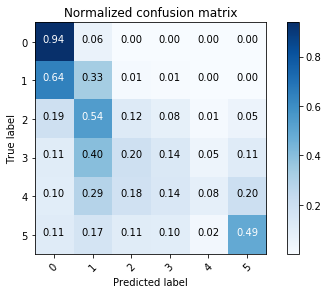

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [19]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_classification_oversampled.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)